In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

import healpy as hp

sys.path.append(os.path.expanduser('~/git/desi-examples/imaging_systematics'))
from plot_healpix_map import plot_map

In [113]:
nside = 512
npix = hp.nside2npix(nside)

map_south = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/imaging_mc/ism_mask/sky_resid_map_{}_south.fits'.format(nside)))
map_south['PHOTSYS'] = 'S'
map_north = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/imaging_mc/ism_mask/sky_resid_map_{}_north.fits'.format(nside)))
map_north['PHOTSYS'] = 'N'

mask = (map_north['DEC']>32.375)
map_north = map_north[mask]
mask = ~np.in1d(map_south['HPXPIXEL'], map_north['HPXPIXEL'])
map_combined = vstack([map_north, map_south[mask]])

In [114]:
sys_dir = '/global/cfs/cdirs/desi/users/rongpu/data/imaging_sys/randoms_stats/0.49.0/resolve/systematics'
sys_south = Table(fitsio.read(os.path.join(sys_dir, 'systematics_south_nside_{}_minobs_1_maskbits_113.fits'.format(nside))))
sys_south['PHOTSYS'] = 'S'
sys_north = Table(fitsio.read(os.path.join(sys_dir, 'systematics_north_nside_{}_minobs_1_maskbits_113.fits'.format(nside))))
sys_north['PHOTSYS'] = 'N'

mask = (sys_north['DEC']>32.375)
sys_north = sys_north[mask]
mask = ~np.in1d(sys_south['HPXPIXEL'], sys_north['HPXPIXEL'])
sys_combined = vstack([sys_north, sys_south[mask]])

sys_columns = ['HPXPIXEL', 'EBV', 'galdepth_gmag', 'galdepth_rmag', 'galdepth_zmag', 'psfdepth_gmag', 'psfdepth_rmag', 'psfdepth_zmag', 'psfdepth_w1mag', 'psfdepth_w2mag', 'galdepth_gmag_ebv', 'galdepth_rmag_ebv', 'galdepth_zmag_ebv', 'psfdepth_gmag_ebv', 'psfdepth_rmag_ebv', 'psfdepth_zmag_ebv', 'psfdepth_w1mag_ebv', 'psfdepth_w2mag_ebv', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'NOBS_G', 'NOBS_R', 'NOBS_Z']
sys_combined = sys_combined[sys_columns]

print(len(map_combined))
map_combined = join(map_combined, sys_combined, join_type='left')
print(len(map_combined))

1570633
1570633


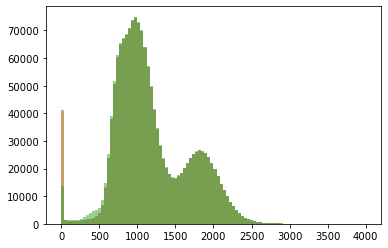

In [115]:
plt.hist(map_combined['nsource_g'], 100, range=(0, 4000), alpha=0.5)
plt.hist(map_combined['nsource_r'], 100, range=(0, 4000), alpha=0.5)
plt.hist(map_combined['nsource_z'], 100, range=(0, 4000), alpha=0.5)
plt.show()

In [116]:
mask = map_combined['nsource_g']>500
mask &= map_combined['nsource_r']>500
mask &= map_combined['nsource_z']>500
print(np.sum(mask)/len(mask))
map_combined = map_combined[mask]

0.9563952877597758


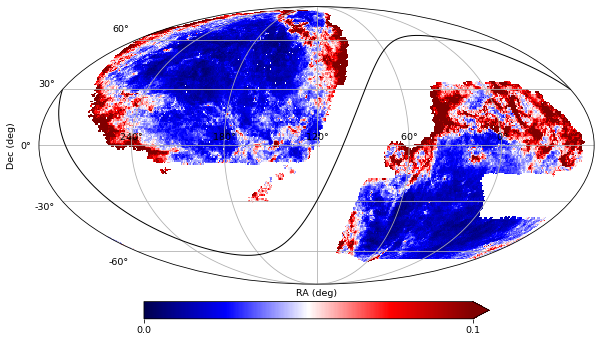

Done! 00:00:00


In [117]:
plot_map(nside, map_combined['HPXPIXEL'], map_combined['EBV'],
         vmin=0, vmax=0.1, cmap='seismic', nest=False,
         xsize=500, show=True)

In [124]:
cat = map_combined.copy()

mask = cat['PHOTSYS']=='S'
cat = cat[mask]

75.39822368615502
1098.3949607562934


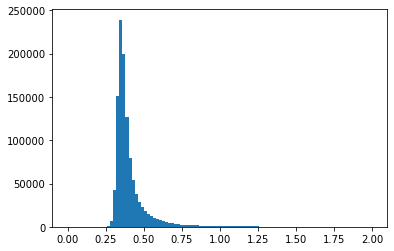

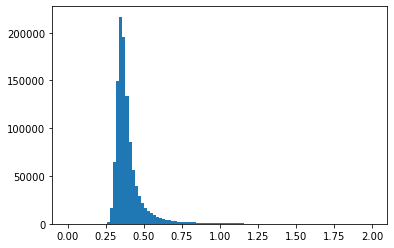

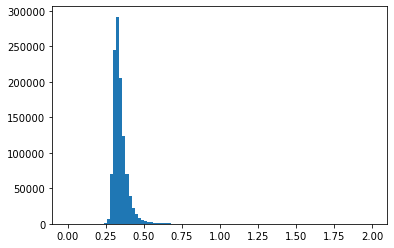

In [125]:
area = (np.pi*7**2-np.pi*5**2)
print(area)
npix = area/(0.262**2)
print(npix)

for band in ['g', 'r', 'z']:
    cat['PSFDEPTH_{}'.format(band.upper())] = (5/10**(-0.4*cat['psfdepth_{}mag'.format(band)]+9))**2
    cat['pixel_noise_'+band] = 1/np.sqrt(cat['PSFDEPTH_{}'.format(band.upper())] * (4 * np.pi * (cat['PSFSIZE_{}'.format(band.upper())]/2.3548)**2))
    plt.hist(cat['sky_nmad_'+band]*area/np.sqrt(cat['pixel_noise_'+band]**2*npix), 100, range=(0, 2))
    plt.show()

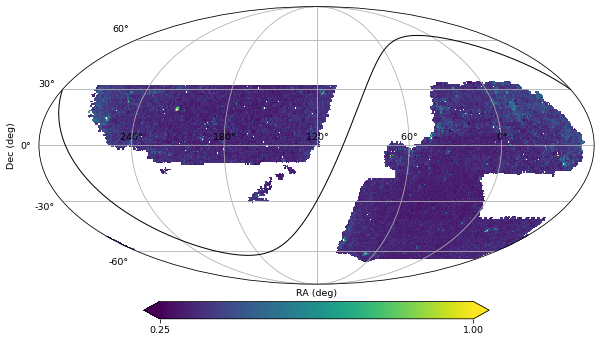

Done! 00:00:00


In [126]:
plot_map(nside, cat['HPXPIXEL'], cat['sky_nmad_'+band]*area/np.sqrt(cat['pixel_noise_'+band]**2*npix),
         vmin=0.25, vmax=1, cmap='viridis', nest=False,
         xsize=500, show=True)